In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [33]:
model_name = "v16_elegammasep"
model_dir = "../models/"+model_name
model_tag = "300x3"
det = "EE"
flavour = "ele"
model_version = 1
numpy_version = 1
limit_files = 10
cols = ["seed_eta", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = f"/storage/ECAL/training_data/wp_comparison/electrons/numpy_wp_ele_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/wp_comparison/gammas/numpy_wp_gamma_v{numpy_version}/training/"

In [34]:
if flavour == "ele":
    datas_ele = []

    i = 0
    for f in glob.glob(files_ele+"*.pkl"):
        if i>limit_files :continue
        d = pickle.load(open(f, "rb")) 
        
        if det == "EB":
            datas_ele.append(d[(d.is_seed == False) & (d.seed_iz == 0)])
        elif det == "EE":
            datas_ele.append(d[(d.is_seed == False) & (d.seed_iz != 0)])
        i+=1

    data_ele = pd.concat(datas_ele, ignore_index=True)
    data_ele["particle"] = "electron"
    print("N events ele: ",len(data_ele))
    
    data = data_ele

elif flavour == "gamma":
    datas_gamma = []
    i = 0
    for f in glob.glob(files_gamma+"*.pkl"):
        if i>limit_files :continue
        d = pickle.load(open(f, "rb"))  
        
        if det == "EB":
            datas_gamma.append(d[(d.is_seed == False) & (d.seed_iz == 0)])
        elif det == "EE":
            datas_gamma.append(d[(d.is_seed == False) & (d.seed_iz != 0)])
        i+=1

    data_gamma = pd.concat(datas_gamma, ignore_index=True)
    data_gamma["particle"] = "gamma"
    print("N events gamma: ",len(data_gamma))
    data = data_gamma

    

N events ele:  1328435


Balance gamma and electron

In [9]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 17692709
Sample in EE: 6153312
Sample in EB in SC: 1349042
Sample in EE in SC: 534642
N in supercluster:  1883684
N out supercluster:  21962337
11.659246986224865


In [13]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  6112489
Not caloMatch samples:  31029667


# Data Preparation

## Reweighting
Only the classes are reweighted, not in Et/eta bins

In [35]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  10.494038554717243


# Array preparation

In [36]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_{}_{}.pkl".format(model_version, det, flavour), "wb"))

In [18]:
scaler.mean_

array([ 3.37056124e-03, -1.74593130e-05,  5.36130602e-03,  1.23126729e+02,
        2.80265087e+01, -3.78455052e-03, -1.50203344e-04,  2.83484634e+00,
        6.40677925e-01,  1.01554926e+00,  2.75737241e-02, -1.77616711e-05,
        3.32061958e-02,  4.89319494e-01,  6.44707573e+00,  1.50138129e-02,
        1.67344891e-02,  2.79334186e+00,  3.08046911e-02,  6.27775699e-05,
        3.31590078e-02,  2.61119929e-01,  1.71585841e+00,  4.72540581e-03,
        3.88576832e-03])

In [19]:
scaler.scale_

array([2.12589494e+00, 1.81044039e+00, 9.99985628e-01, 1.46820096e+02,
       3.00979511e+01, 1.12098571e-01, 3.27104817e-01, 3.59360965e+00,
       9.23493314e-01, 1.99068714e-01, 1.25832325e-02, 3.53237934e-04,
       1.50224864e-02, 4.04929254e-01, 6.05649518e+00, 8.35942362e-03,
       1.01887911e-02, 1.01619895e+01, 2.27360544e-02, 5.72288469e-04,
       2.39331450e-02, 3.07576377e+00, 2.33820102e+00, 7.15756749e-03,
       8.16390373e-03])

In [10]:
print("N. samples:", X.shape[0])

N. samples: 11895361


In [8]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.15)

# Training

In [11]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *
from importlib import reload

In [38]:
model_EB = keras.models.load_model(model_dir+"/model_v{}_{}_{}.hd5".format(1,"EB", flavour))
model_EE = keras.models.load_model(model_dir+"/model_v{}_{}_{}.hd5".format(1,"EE", flavour))

# AUC by eta and Et bin

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve

data["y"] =  model_EE.predict(scaler.transform(data[cols].values), batch_size=4096)

ets = [0,20,40,60,80,100]
if det=="EB":
    etas = [0, 0.4,0.8, 1.2,1.479]
if det=="EE":
    etas = [1.479,1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)


[-1.  0.  1.  2.  3.  4.  5.]


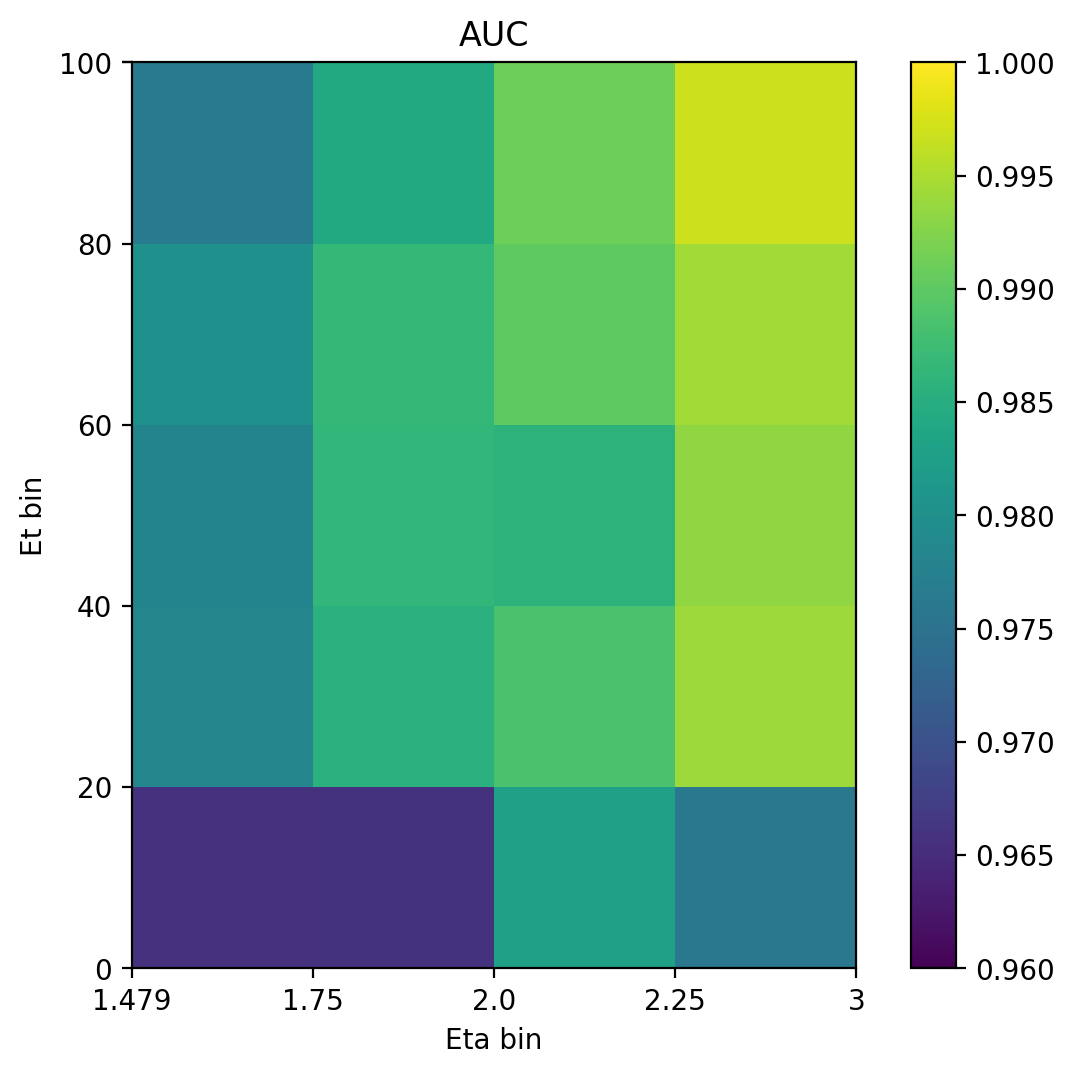

In [43]:
a = result.values.reshape((len(etas)-1,len(ets)-1))
fig,ax1 = plt.subplots(figsize=(7,6), dpi=200)

c = ax1.imshow(a.T, vmax=1, vmin=0.96)
ax1.set_xlabel("Eta bin")
ax1.set_ylabel("Et bin")
ax1.set_title("AUC")

locs,labels  = plt.xticks()
locs = np.append(locs, locs[-2]+1)
plt.xticks((locs-0.5)[1::2], etas)


locs,labels  = plt.yticks()
print(locs)
locs = np.append(locs, locs[-2]+1)
plt.yticks((locs-0.5)[1::], ets)

plt.colorbar(c)